In [2]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy.ndimage import center_of_mass
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import astropy.coordinates as coord
from astropy import units as u
from astropy.coordinates import Angle

#### **Select the 20 brightest objects in the Observation map**

In [3]:
%store -r brightest20_obs

#### **Point source only P map**

In [4]:
%store -r ps_map_P_obs

In [6]:
%store -r lon

In [8]:
%store -r lat

In [10]:
%store -r xsize

In [11]:
%store -r reso

In [ ]:
ps_map_P_obs_patches = [hp.gnomview(ps_map_P_obs, rot=[lon[i], lat[i]], xsize = xsize, reso = reso, return_projected_map = True, no_plot = True) for i in range(len(lon))]

In [ ]:
%store ps_map_P_obs_patches

#### **Patch comparison**

In [ ]:
# Store the prediction
%store -r prediction_P_64pix_9epoch_10batch_sol

In [ ]:
# Store the observation
%store -r map_cut_data_P_obs

In [ ]:
patch_numbers = [item[0] for item in brightest20_obs]
peak_patch_x = [item[2] for item in brightest20_obs]
peak_patch_y = [item[1] for item in brightest20_obs]

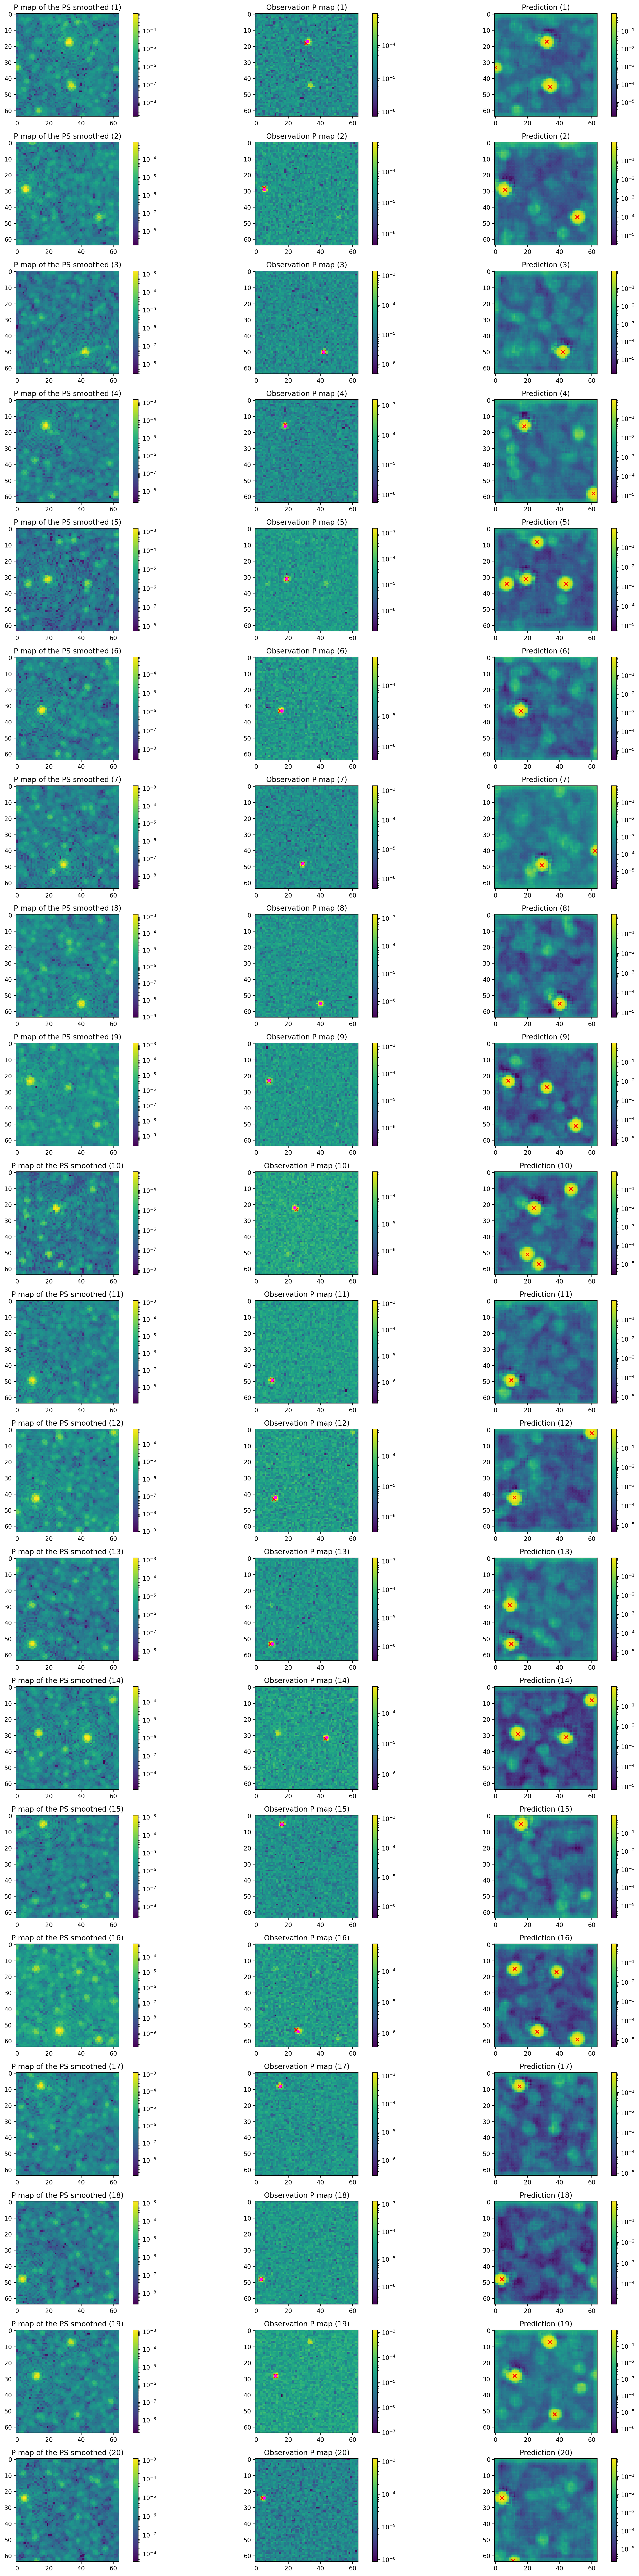

In [33]:
fig, axes = plt.subplots(20, 3, figsize=(18, 60), dpi=200)

for i, (patch_number, peak_x, peak_y) in enumerate(zip(patch_numbers[:20], peak_patch_x[:20], peak_patch_y[:20])):
    
    def test(observation, prediction, n=patch_number, peak_distance_tol=5, position_tol=5): 
        observation = np.squeeze(observation[n])
        prediction = np.squeeze(prediction[n])
        observation_peaks = peak_local_max(observation[:, :], threshold_rel=0.9, min_distance=peak_distance_tol, exclude_border=False)
        prediction_peaks = peak_local_max(prediction[:, :], threshold_abs=0.3, min_distance=peak_distance_tol, exclude_border=False)
        true_detections = []
        for observation_peak in observation_peaks:
            for pred_peak in prediction_peaks:
                distance = np.sqrt((observation_peak[0] - pred_peak[0]) ** 2 + (observation_peak[1] - pred_peak[1]) ** 2)
                if distance <= position_tol:
                    true_detections.append((observation_peak, pred_peak))

        false_detections = len(prediction_peaks) - len(true_detections)
        return true_detections, false_detections, prediction_peaks, observation_peaks, observation, prediction  
    
    def test_labels(labels_map, map_cut_data_P, n=patch_number, peak_distance_tol=5, position_tol=5):
        labels_map = np.squeeze(labels_map[n])
        map_cut_data_P = np.squeeze(map_cut_data_P[n])
        labels = label(labels_map)
        labels_peaks = [center_of_mass(labels_map, labels, [j+1]) for j in range(np.max(labels))]
        labels_peaks = sum(labels_peaks, [])  # join lists of lists
        labels_peaks = np.array(labels_peaks)  # convert to array so that it has the same format as prediction_peaks
        
        return labels_peaks, labels_map, map_cut_data_P
    
        
    # S_new_obs plot
    ax1 = axes[i, 0]    
    sc1 = ax1.imshow(ps_map_P_obs_patches[patch_number], norm=LogNorm())
    cbar1 = fig.colorbar(sc1, ax=ax1)
    ax1.set_title(f"P map of the PS smoothed ({i+1})")

        
    # Observation
    ax2 = axes[i, 1]  
    image_data2 = test(map_cut_data_P_obs, prediction_P_64pix_9epoch_10batch_sol)[4]
    sc2 = ax2.imshow(image_data2, norm=LogNorm())
    ax2.scatter(x=test(map_cut_data_P_obs, prediction_P_64pix_9epoch_10batch_sol)[3][:, 1],
                y=test(map_cut_data_P_obs, prediction_P_64pix_9epoch_10batch_sol)[3][:, 0], c='red', marker='x')
    ax2.scatter(x=peak_x, y=peak_y, color='magenta', s=20)
    cbar2 = fig.colorbar(sc2, ax=ax2)
    ax2.set_title(f"Observation P map ({i+1})")

    
    # Prediction
    ax3 = axes[i, 2]  
    image_data3 = test(map_cut_data_P_obs, prediction_P_64pix_9epoch_10batch_sol)[5]
    sc3 = ax3.imshow(image_data3, norm=LogNorm())
    ax3.scatter(x=test(map_cut_data_P_obs, prediction_P_64pix_9epoch_10batch_sol)[2][:, 1],
                y=test(map_cut_data_P_obs, prediction_P_64pix_9epoch_10batch_sol)[2][:, 0], c='red', marker='x')
    cbar3 = fig.colorbar(sc3, ax=ax3)
    ax3.set_title(f"Prediction ({i+1})")



plt.tight_layout()  
plt.show()
